<div align="center">
  <a href="https://www.davivienda.com/wps/portal/personas/nuevo">
    <img src="https://upload.wikimedia.org/wikipedia/en/thumb/b/b1/Davivienda_logo.svg/1200px-Davivienda_logo.svg.png" alt="Logo" width="300" height="100">
  </a>

  <h2 align="center">Prueba Técnica Davivienda aDNE - Especialista I</h2>
  <h2 align="center">Notebook de Implementación Clasificador de Imágenes Con Contenido/Sin Contenido</h2>
  <h4 align="center">Luvan Tabares</h4>
    
***

  <p align="left">
    Se requiere el desarrollo de un modelo con la capacidad de identificar si un documento contiene información relevante o no. En esta clasificación, se consideran como documentos sin contenido aquellos que solo presentan un pie de página o están membreteados, pero carecen de información significativa. Para esta tarea, se dispone de una carpeta con 100 imágenes con contenido y 147 imágenes sin contenido. 
    
  <p align="left">
    Se propone aumentar el conjunto de datos buscando imágenes adicionales en datasets públicos, con el objetivo de alcanzar un total de 1000 imágenes, distribuidas equitativamente en 500 con contenido y 500 sin contenido. Para lograrlo, se utilizarán técnicas preliminares de identificación de imágenes sin contenido, tales como el análisis del peso de la imagen y el valor del laplaciano. Estos parámetros deberán ser ajustados para cada dataset con el fin de asegurar una correcta extracción de las imágenes sin contenido. 
    
  <p align="left">
    Una vez aumentado el dataset, se procederá a entrenar un modelo utilizando TensorFlow y una red neuronal convolucional (CNN). Los datos se dividirán en conjuntos de entrenamiento y validación. Posteriormente, se extraerá la matriz de confusión únicamente de los datos suministrados originalmente, con el fin de evaluar el rendimiento del modelo.    
    
  </p>
</div>

## Tabla de contenidos

1. [Instalación de librerías y llamado de librerías](#first1) <br />
2. [EDA - Análisis Exploratorio de Datos](#second1) <br />
3. [Preprocesamiento de los textos](#third1) <br />
4. [Entrenamiento de modelos usando sklearn](#fourth1) <br />
5. [Entrenamiento de modelos usando Tensorflow](#fifth1) <br />
6. [Entrenamiento de modelos usando spaCy](#sixth1) <br />
7. [Conclusión](#seventh1) <br />


## 1. Librerias a instalar <a id="first1"></a>

In [ ]:
# !pip install -r requirements.txt

## Cargar las librerías necesarias

In [1]:
import os
from PIL import Image, ImageOps
import statistics
import shutil
import cv2
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
import matplotlib.pyplot as plt

In [2]:


def invert_image_extract_size(image_path, output_path, invert_colors):
    if invert_colors:
        with Image.open(image_path) as img:
            inverted_image = ImageOps.invert(img)
            inverted_image.save(output_path)
            file_size = os.path.getsize(output_path)
            return file_size
    else:
        file_size = os.path.getsize(image_path)
        return file_size

def invert_colors_process_images(source_dir, dest_dir, max_workers, invert_colors):

    if not os.path.exists(dest_dir) and dest_dir != "No_Path":
        os.makedirs(dest_dir)

    image_sizes = []
    futures = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        print(f"Using {executor._max_workers} worker threads")
        for root, _, files in os.walk(source_dir):
            for file in files:
                if file.endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif')):
                    source_file = os.path.join(root, file)
                    dest_file = os.path.join(dest_dir, file)
                    futures.append(executor.submit(invert_image_extract_size, source_file, dest_file, invert_colors))
    
        for future in futures:
            image_sizes.append(future.result())

    return image_sizes

def extract_statistics(image_sizes):
    if not image_sizes:
        return {}

    stats = {
        'max': max(image_sizes),
        'min': min(image_sizes),
        'mean': statistics.mean(image_sizes),
        'std_dev': statistics.stdev(image_sizes) if len(image_sizes) > 1 else 0
    }
    
    return stats

def plot_histogram(image_sizes):
    plt.hist(image_sizes, bins=10, edgecolor='black')
    plt.title('Distribution of Image File Sizes')
    plt.xlabel('File Size (KB)')
    plt.ylabel('Frequency')
    plt.show()

def find_blank_threshold(stats):
    threshold = stats['mean'] - stats['std_dev']
    return threshold

def move_image(image_file, destination_folder, size_threshold_bytes, per_threshold_size):
    try:
        image_size = image_file.stat().st_size
        if image_size < size_threshold_bytes * per_threshold_size:
            shutil.move(str(image_file), Path(destination_folder) / image_file.name)
            print(f"Moved {image_file.name} to {destination_folder}")
    except Exception as e:
        print(f"Error moving {image_file.name}: {e}")

def move_small_images(source_folder, destination_folder, size_threshold_kb, max_workers, per_threshold_size):
    try:
        # Convert size threshold to bytes
        size_threshold_bytes = size_threshold_kb * 1024

        # Ensure the destination folder exists
        Path(destination_folder).mkdir(parents=True, exist_ok=True)

        # List PNG files in source folder recursively
        image_files = list(Path(source_folder).rglob("*.png"))

        # Use ThreadPoolExecutor to parallelize moving images
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            print(f"Using {executor._max_workers} worker threads")
            # Submit each move operation to the executor
            futures = [executor.submit(move_image, image_file, destination_folder, size_threshold_bytes, per_threshold_size) for image_file in image_files]

            # Wait for all futures to complete
            for future in as_completed(futures):
                future.result()  # Retrieve and handle any exceptions

    except Exception as e:
        print(f"Error processing images: {e}")

def calculate_laplacian(image_path):
    try:
        if not os.path.isfile(image_path):
            raise FileNotFoundError(f"File not found: {image_path}")

        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            raise ValueError(f"Unable to read the image: {image_path}")

        laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()

        return image_path, laplacian_var

    except Exception as e:
        print(f"Error calculating Laplacian variance for {image_path}: {e}")
        return image_path, float('inf')

def process_images_laplacian(source_folder, max_workers):
    try:
        images = []
        image_paths = [os.path.join(source_folder, filename) for filename in os.listdir(source_folder) if filename.endswith(".png")]

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = {executor.submit(calculate_laplacian, image_path): image_path for image_path in image_paths}

            for future in as_completed(futures):
                image_path = futures[future]
                try:
                    image_path, laplacian_value = future.result()
                    images.append((image_path, laplacian_value))
                except Exception as e:
                    print(f"Error processing image {image_path}: {e}")

        return images

    except Exception as e:
        print(f"Error processing images: {e}")

def move_image_threshold(path, value, destination_folder, threshold):
    if value < threshold:
        # Extract filename from path
        filename = os.path.basename(path)
        # Construct destination path
        destination = os.path.join(destination_folder, filename)
        # Move file
        shutil.move(path, destination)
        print(f"Moved {path} to {destination}")

def move_images_by_laplacian(images, destination_folder, threshold, per_threshold_laplaciano):
    # Adjust threshold
    threshold = per_threshold_laplaciano * threshold
    print(f"Using threshold: {threshold:.2f}")
    
    with ThreadPoolExecutor() as executor:
        futures = []
        for path, value in images:
            futures.append(executor.submit(move_image_threshold, path, value, destination_folder, threshold))
        
        for future in as_completed(futures):
            try:
                future.result()
            except Exception as e:
                print(f"Error moving image: {e}")

def extract_blank_images_size_laplacian(source_dir, dest_dir, destination_folder, max_workers, invert_colors, per_threshold_laplaciano, per_threshold_size):
    
    image_sizes = invert_colors_process_images(source_dir, dest_dir, max_workers, invert_colors)
    
    image_sizes_kb = [size / 1024 for size in image_sizes]
    stats = extract_statistics(image_sizes_kb)

    print(f"Statistics: {stats}")

    print("Deleting oversized images")
    size_limit = stats['mean'] + stats['std_dev']
    image_sizes_kb = [size for size in image_sizes_kb if size < size_limit]
    stats = extract_statistics(image_sizes_kb)
    print(f"Statistics: {stats}")

    plot_histogram(image_sizes_kb)

    threshold_kb = find_blank_threshold(stats)
    print(f"Threshold for detecting blank pages: {threshold_kb:.2f} KB")

    blank_pages = [size for size in image_sizes_kb if size < threshold_kb]
    print(f"Number of detected blank pages: {len(blank_pages)}")

    # Define the source and destination folders
    if dest_dir != "No_Path":
        source_folder = dest_dir
    else:
        source_folder = source_dir

    move_small_images(source_folder, destination_folder, threshold_kb, max_workers, per_threshold_size)

    #####
    images = process_images_laplacian(source_folder, max_workers)
    images_laplacian_values = [img[1] for img in images]

    stats_laplacian = extract_statistics(images_laplacian_values)
    print(f"Statistics: {stats_laplacian}")

    print("Deleting images with high Laplacian variance")
    size_limit = stats_laplacian['mean'] + stats_laplacian['std_dev']
    images_laplacian_values = [value for value in images_laplacian_values if value < size_limit]
    stats_laplacian = extract_statistics(images_laplacian_values)
    print(f"Statistics: {stats_laplacian}")

    plot_histogram(images_laplacian_values)

    threshold_laplacian = find_blank_threshold(stats_laplacian)
    print(f"Threshold for detecting blank pages: {threshold_laplacian:.2f}")

    move_images_by_laplacian(images, destination_folder, threshold_laplacian, per_threshold_laplaciano)



Using 32 worker threads
Statistics: {'max': 446.19921875, 'min': 1.873046875, 'mean': 45.57281144016473, 'std_dev': 41.49693341491733}
Deleting oversized images
Statistics: {'max': 86.9892578125, 'min': 1.873046875, 'mean': 35.584721467391304, 'std_dev': 21.706496014160617}


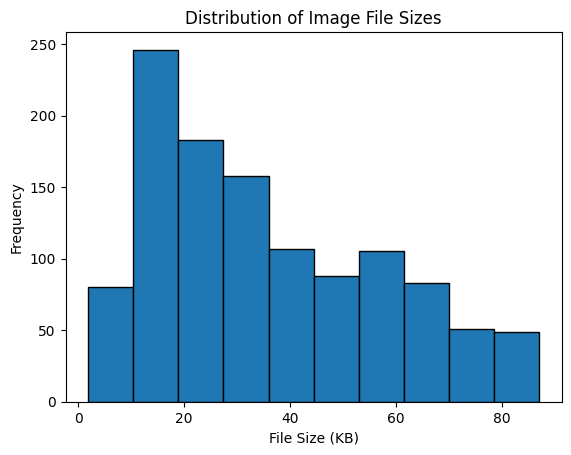

Threshold for detecting blank pages: 13.88 KB
Number of detected blank pages: 173
Using 32 worker threads
Moved qit05f00-page2_1.png to data_processed/Tobacco 800 Dataset blank_images
Moved cgy54f00_2.png to data_processed/Tobacco 800 Dataset blank_images
Moved qit05f00-page2_23.png to data_processed/Tobacco 800 Dataset blank_images
Moved eey54f00_2.png to data_processed/Tobacco 800 Dataset blank_images
Moved hti31a00_2.png to data_processed/Tobacco 800 Dataset blank_images
Moved cgx54f00_2.png to data_processed/Tobacco 800 Dataset blank_images
Moved dic45f00_4.png to data_processed/Tobacco 800 Dataset blank_images
Moved ivw54f00_2.png to data_processed/Tobacco 800 Dataset blank_images
Moved qit05f00-page2_21.png to data_processed/Tobacco 800 Dataset blank_images
Moved jnx54f00_2.png to data_processed/Tobacco 800 Dataset blank_images
Moved ofy54f00_2.png to data_processed/Tobacco 800 Dataset blank_images
Moved zqc25f00_2.png to data_processed/Tobacco 800 Dataset blank_images
Moved aww5

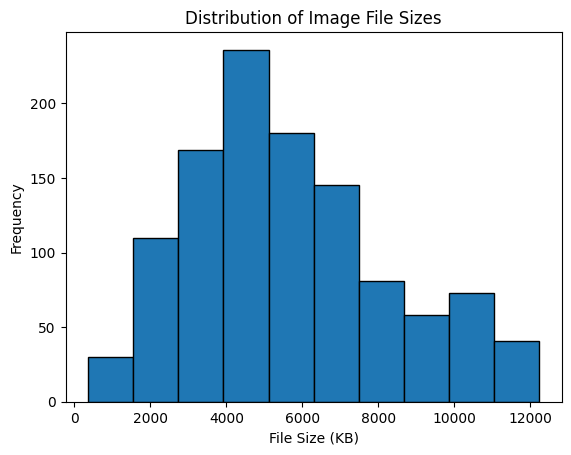

Threshold for detecting blank pages: 2990.49
Using threshold: 897.15
Moved data_processed/Tobacco 800 Dataset whitened/crr09c00_2.png to data_processed/Tobacco 800 Dataset blank_images/crr09c00_2.png
Moved data_processed/Tobacco 800 Dataset whitened/qin54c00_2.png to data_processed/Tobacco 800 Dataset blank_images/qin54c00_2.png
Moved data_processed/Tobacco 800 Dataset whitened/erk44a00_2.png to data_processed/Tobacco 800 Dataset blank_images/erk44a00_2.png
Moved data_processed/Tobacco 800 Dataset whitened/gzr94e00-page01_2.png to data_processed/Tobacco 800 Dataset blank_images/gzr94e00-page01_2.png
Moved data_processed/Tobacco 800 Dataset whitened/pek94c00_3.png to data_processed/Tobacco 800 Dataset blank_images/pek94c00_3.png
Moved data_processed/Tobacco 800 Dataset whitened/btt85f00-page2_1.png to data_processed/Tobacco 800 Dataset blank_images/btt85f00-page2_1.png
Moved data_processed/Tobacco 800 Dataset whitened/vrr09c00-page03_1.png to data_processed/Tobacco 800 Dataset blank_ima

In [3]:
# Usage example
source_dir = 'data_original/Tobacco 800 Dataset/tobacco800'
dest_dir = 'data_processed/Tobacco 800 Dataset whitened'
destination_folder = "data_processed/Tobacco 800 Dataset blank_images"
max_workers = None
invert_colors = True
per_threshold_size = 0.35
per_threshold_laplaciano = 0.3


extract_blank_images_size_laplacian(source_dir, dest_dir, destination_folder, max_workers, invert_colors, per_threshold_laplaciano, per_threshold_size)

In [7]:
def convert_file(jpg_path, output_folder):
    jpg_image = Image.open(jpg_path)
    png_path = os.path.join(output_folder, os.path.splitext(os.path.basename(jpg_path))[0] + ".png")
    jpg_image.save(png_path, "PNG")
    print(f"Converted {jpg_path} to {png_path}")

def convert_jpg_to_png(input_folder, output_folder):
    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # List to hold futures for monitoring completion
    futures = []

    # ThreadPoolExecutor to manage concurrent tasks
    with ThreadPoolExecutor() as executor:
        # Walk through each subdirectory
        for root, _, files in os.walk(input_folder):
            for file in files:
                if file.endswith(".jpg"):
                    jpg_path = os.path.join(root, file)
                    # Submit each JPG file conversion task to ThreadPoolExecutor
                    futures.append(executor.submit(convert_file, jpg_path, output_folder))

    # Wait for all conversions to complete
    for future in as_completed(futures):
        try:
            future.result()  # Ensure any exceptions raised in threads are propagated
        except Exception as e:
            print(f"Exception occurred: {e}")

In [8]:
input_folder = "data_original/Tobacco3482 Dataset"  # Update with your folder path
output_folder = "data_processed/Tobacco3482 Dataset PNG"  # Update with your desired output folder path
convert_jpg_to_png(input_folder, output_folder)

Converted data_original/Tobacco3482 Dataset/ADVE/517508450+-8453.jpg to data_processed/Tobacco3482 Dataset PNG/517508450+-8453.png
Converted data_original/Tobacco3482 Dataset/ADVE/0030049569.jpg to data_processed/Tobacco3482 Dataset PNG/0030049569.png
Converted data_original/Tobacco3482 Dataset/ADVE/517950663+-0671.jpg to data_processed/Tobacco3482 Dataset PNG/517950663+-0671.png
Converted data_original/Tobacco3482 Dataset/ADVE/509134595+-4596.jpg to data_processed/Tobacco3482 Dataset PNG/509134595+-4596.png
Converted data_original/Tobacco3482 Dataset/ADVE/93422915.jpg to data_processed/Tobacco3482 Dataset PNG/93422915.png
Converted data_original/Tobacco3482 Dataset/ADVE/2070262428_2429.jpg to data_processed/Tobacco3482 Dataset PNG/2070262428_2429.png
Converted data_original/Tobacco3482 Dataset/ADVE/2061199558.jpg to data_processed/Tobacco3482 Dataset PNG/2061199558.png
Converted data_original/Tobacco3482 Dataset/ADVE/2084412816_2817.jpg to data_processed/Tobacco3482 Dataset PNG/208441

Using 32 worker threads
Statistics: {'max': 3964.720703125, 'min': 19.3955078125, 'mean': 492.5141206113584, 'std_dev': 379.2579125924531}
Deleting oversized images
Statistics: {'max': 871.5947265625, 'min': 19.3955078125, 'mean': 389.8655774140778, 'std_dev': 227.1343484122752}


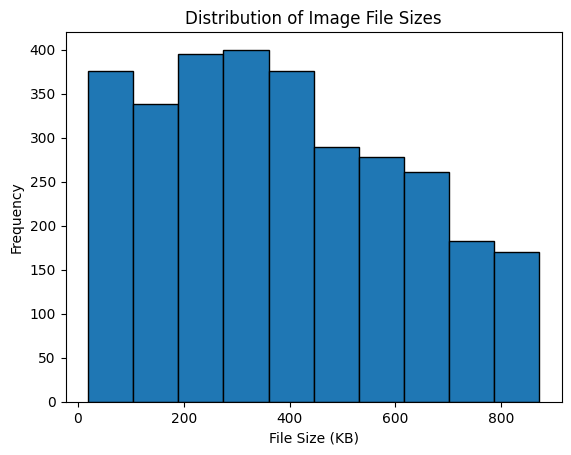

Threshold for detecting blank pages: 162.73 KB
Number of detected blank pages: 596
Using 32 worker threads
Moved 2085272616a.png to data_processed/Tobacco3482 Dataset blank_images
Moved 2075574247c_4248.png to data_processed/Tobacco3482 Dataset blank_images
Moved 2082693424a.png to data_processed/Tobacco3482 Dataset blank_images
Moved 2085791853c_1854.png to data_processed/Tobacco3482 Dataset blank_images
Moved 0000642640.png to data_processed/Tobacco3482 Dataset blank_images
Moved 2085752507d.png to data_processed/Tobacco3482 Dataset blank_images
Moved 0000002770.png to data_processed/Tobacco3482 Dataset blank_images
Moved 2071191029.png to data_processed/Tobacco3482 Dataset blank_images
Moved 2085696947f_6948.png to data_processed/Tobacco3482 Dataset blank_images
Moved 2073414412.png to data_processed/Tobacco3482 Dataset blank_images
Moved 2085770392c_0393.png to data_processed/Tobacco3482 Dataset blank_images
Moved 2085126533a.png to data_processed/Tobacco3482 Dataset blank_images
M

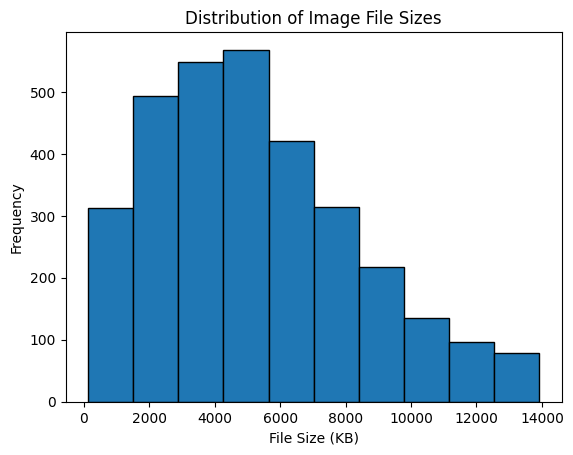

Threshold for detecting blank pages: 2202.37
Using threshold: 660.71
Moved data_processed/Tobacco3482 Dataset PNG/2063603124.png to data_processed/Tobacco3482 Dataset blank_images/2063603124.png
Moved data_processed/Tobacco3482 Dataset PNG/2085788705.png to data_processed/Tobacco3482 Dataset blank_images/2085788705.png
Moved data_processed/Tobacco3482 Dataset PNG/2084289636b.png to data_processed/Tobacco3482 Dataset blank_images/2084289636b.png
Moved data_processed/Tobacco3482 Dataset PNG/2085782997a.png to data_processed/Tobacco3482 Dataset blank_images/2085782997a.png
Moved data_processed/Tobacco3482 Dataset PNG/50488503-8503.png to data_processed/Tobacco3482 Dataset blank_images/50488503-8503.png
Moved data_processed/Tobacco3482 Dataset PNG/2083647284d_7285.png to data_processed/Tobacco3482 Dataset blank_images/2083647284d_7285.png
Moved data_processed/Tobacco3482 Dataset PNG/2060540658.png to data_processed/Tobacco3482 Dataset blank_images/2060540658.png
Moved data_processed/Tobacc

In [9]:
# Usage example
source_dir = 'data_processed/Tobacco3482 Dataset PNG'
dest_dir = 'No_Path'
destination_folder = "data_processed/Tobacco3482 Dataset blank_images"
max_workers = None
invert_colors = False
per_threshold_laplaciano = 0.3
per_threshold_size = 0.25

extract_blank_images_size_laplacian(source_dir, dest_dir, destination_folder, max_workers, invert_colors, per_threshold_laplaciano, per_threshold_size)

In [10]:
# Function to convert TIFF to PNG
def convert_tiff_to_png(tiff_path, output_folder):
    try:
        # Open the TIFF image
        tiff_image = Image.open(tiff_path)
        # Construct the output PNG path
        png_path = os.path.join(output_folder, os.path.splitext(os.path.basename(tiff_path))[0] + ".png")
        # Save as PNG
        tiff_image.save(png_path, "PNG")
        print(f"Converted {tiff_path} to {png_path}")
    except Exception as e:
        print(f"Error converting {tiff_path}: {e}")

# Function to process each file
def process_file(file_path, output_folder):
    if file_path.lower().endswith(".tif") or file_path.lower().endswith(".tiff"):
        convert_tiff_to_png(file_path, output_folder)

# Parallel execution using ThreadPoolExecutor
def parallel_convert_tiff_to_png(input_folder, output_folder):
    # Ensure output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # List all files in input_folder and its subdirectories
    all_files = []
    for root, _, files in os.walk(input_folder):
        for file in files:
            file_path = os.path.join(root, file)
            all_files.append(file_path)

    # Use ThreadPoolExecutor to convert images concurrently
    with ThreadPoolExecutor() as executor:
        futures = []
        for file_path in all_files:
            futures.append(executor.submit(process_file, file_path, output_folder))
        
        # Wait for all tasks to complete
        for future in as_completed(futures):
            future.result()


In [11]:
# Example usage:
input_folder = "data_original/RVL-CDIP Dataset"  # Update with your folder path
output_folder = "data_processed/RVL-CDIP Dataset PNG"  # Update with your desired output folder path
parallel_convert_tiff_to_png(input_folder, output_folder)

Converted data_original/RVL-CDIP Dataset/letter/71148963.tif to data_processed/RVL-CDIP Dataset PNG/71148963.png
Converted data_original/RVL-CDIP Dataset/letter/50521502-1503.tif to data_processed/RVL-CDIP Dataset PNG/50521502-1503.png
Converted data_original/RVL-CDIP Dataset/letter/10399923.tif to data_processed/RVL-CDIP Dataset PNG/10399923.png
Converted data_original/RVL-CDIP Dataset/letter/0001090624.tif to data_processed/RVL-CDIP Dataset PNG/0001090624.png
Converted data_original/RVL-CDIP Dataset/letter/83784225.tif to data_processed/RVL-CDIP Dataset PNG/83784225.png
Converted data_original/RVL-CDIP Dataset/letter/50618029-8029.tif to data_processed/RVL-CDIP Dataset PNG/50618029-8029.png
Converted data_original/RVL-CDIP Dataset/letter/504376846_504376852.tif to data_processed/RVL-CDIP Dataset PNG/504376846_504376852.png
Converted data_original/RVL-CDIP Dataset/letter/518575176_518575179.tif to data_processed/RVL-CDIP Dataset PNG/518575176_518575179.png
Converted data_original/RVL-

/home/luvanpc/anaconda3/envs/clasi_images/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Converted data_original/RVL-CDIP Dataset/scientific_publication/92489450_92489453.tif to data_processed/RVL-CDIP Dataset PNG/92489450_92489453.pngConverted data_original/RVL-CDIP Dataset/scientific_publication/10419122_10419128.tif to data_processed/RVL-CDIP Dataset PNG/10419122_10419128.png
Converted data_original/RVL-CDIP Dataset/scientific_publication/10420865.tif to data_processed/RVL-CDIP Dataset PNG/10420865.png

Converted data_original/RVL-CDIP Dataset/scientific_publication/PUBLICATIONS000016-0.tif to data_processed/RVL-CDIP Dataset PNG/PUBLICATIONS000016-0.png
Converted data_original/RVL-CDIP Dataset/scientific_publication/2085530601_0619.tif to data_processed/RVL-CDIP Dataset PNG/2085530601_0619.png
Converted data_original/RVL-CDIP Dataset/scientific_publication/2060531720_2060531724.tif to data_processed/RVL-CDIP Dataset PNG/2060531720_2060531724.png
Converted data_original/RVL-CDIP Dataset/scientific_publication/00399159_9164.tif to data_processed/RVL-CDIP Dataset PNG/00399

Using 32 worker threads
Statistics: {'max': 756.9267578125, 'min': 3.958984375, 'mean': 101.34573718602329, 'std_dev': 76.95883314592074}
Deleting oversized images
Statistics: {'max': 178.2841796875, 'min': 3.958984375, 'mean': 79.88931295145996, 'std_dev': 42.659460062980685}


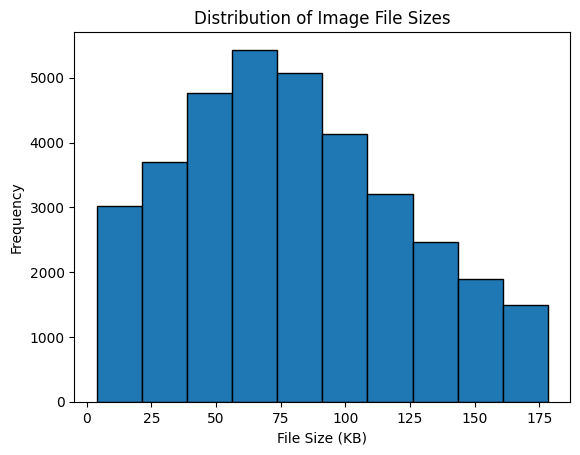

Threshold for detecting blank pages: 37.23 KB
Number of detected blank pages: 6388
Using 32 worker threads
Moved 2044065845.png to data_processed/RVL-CDIP Dataset blank_images
Moved 91383093.png to data_processed/RVL-CDIP Dataset blank_images
Moved 50420594-0596.png to data_processed/RVL-CDIP Dataset blank_images
Moved 2042386755.png to data_processed/RVL-CDIP Dataset blank_images
Moved 2063821563_1599.png to data_processed/RVL-CDIP Dataset blank_images
Moved 2042927907.png to data_processed/RVL-CDIP Dataset blank_images
Moved 2071646766_6778.png to data_processed/RVL-CDIP Dataset blank_images
Moved 2044115217.png to data_processed/RVL-CDIP Dataset blank_images
Moved 2046721605.png to data_processed/RVL-CDIP Dataset blank_images
Moved 2501096788.png to data_processed/RVL-CDIP Dataset blank_images
Moved 98098734_8735.png to data_processed/RVL-CDIP Dataset blank_images
Moved 2501153738.png to data_processed/RVL-CDIP Dataset blank_images
Moved 0011847187.png to data_processed/RVL-CDIP Dat

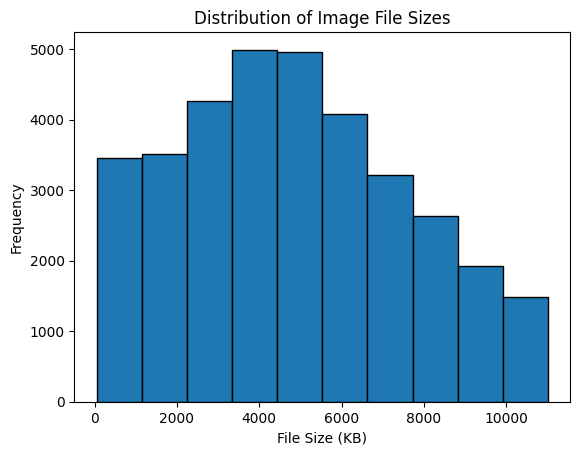

Threshold for detecting blank pages: 2105.24
Using threshold: 210.52
Moved data_processed/RVL-CDIP Dataset PNG/2046892440.png to data_processed/RVL-CDIP Dataset blank_images/2046892440.png
Moved data_processed/RVL-CDIP Dataset PNG/2062406432.png to data_processed/RVL-CDIP Dataset blank_images/2062406432.png
Moved data_processed/RVL-CDIP Dataset PNG/2072707981.png to data_processed/RVL-CDIP Dataset blank_images/2072707981.png
Moved data_processed/RVL-CDIP Dataset PNG/2023741642_2023741678.png to data_processed/RVL-CDIP Dataset blank_images/2023741642_2023741678.png
Moved data_processed/RVL-CDIP Dataset PNG/87928126.png to data_processed/RVL-CDIP Dataset blank_images/87928126.png
Moved data_processed/RVL-CDIP Dataset PNG/2067540451.png to data_processed/RVL-CDIP Dataset blank_images/2067540451.png
Moved data_processed/RVL-CDIP Dataset PNG/2046027063.png to data_processed/RVL-CDIP Dataset blank_images/2046027063.png
Moved data_processed/RVL-CDIP Dataset PNG/2081333383_3386.png to data_pro

In [12]:
# Usage example
source_dir = 'data_processed/RVL-CDIP Dataset PNG'
dest_dir = 'No_Path'
destination_folder = "data_processed/RVL-CDIP Dataset blank_images"
max_workers = None
invert_colors = False
per_threshold_laplaciano = 0.1
per_threshold_size = 0.15

extract_blank_images_size_laplacian(source_dir, dest_dir, destination_folder, max_workers, invert_colors, per_threshold_laplaciano, per_threshold_size)